In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as data
import random
import matplotlib.pyplot as plt
from torchvision import models
from torchvision.models import ResNet50_Weights




SEED = 309
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

BATCH_SIZE = 64
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor of smaller size to reduece memory usage
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    #ImageNet training dataset mean and standard deviation
])

original_data = datasets.ImageFolder(root='train_data', transform=transform)
removed_images_data = datasets.ImageFolder(root='train_data_removed', transform=transform)
added_data = datasets.ImageFolder(root='train_data_added_images', transform=transform)

In [16]:

train_data_og, test_data_og = data.random_split(original_data, [0.8, 0.2])
train_data_added, test_data_added = data.random_split(added_data, [0.8, 0.2])
train_data_removed, test_data_removed = data.random_split(removed_images_data, [0.8, 0.2])

train_loader_og = data.DataLoader(train_data_og, shuffle=True, batch_size=BATCH_SIZE)
test_loader_og = data.DataLoader(test_data_og, batch_size=BATCH_SIZE)

train_loader_added = data.DataLoader(train_data_added, shuffle=True, batch_size=BATCH_SIZE)
test_loader_added = data.DataLoader(test_data_added, batch_size=BATCH_SIZE)

train_loader_removed = data.DataLoader(train_data_removed, shuffle=True, batch_size=BATCH_SIZE)
test_loader_removed = data.DataLoader(test_data_removed, batch_size=BATCH_SIZE)


In [17]:
CNN = models.resnet50(weights=None)  # Set weights=None to avoid downloading weights

CNN.load_state_dict(torch.load('resnet50-11ad3fa6.pth', map_location=device))
CNN.fc = nn.Linear(CNN.fc.in_features, 3)
CNN = CNN.to(device)

criterion_CNN = nn.CrossEntropyLoss().to(device)
optimizer_CNN = optim.Adam(CNN.parameters(), lr=0.001)

/var/folders/by/cby83_2162398rc3ls4z9y_h0000gn/T/ipykernel_12041/2365312405.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  CNN.load_state_dict(torch.load('resnet50-11ad

In [18]:

# Function to train the model
def train(model, train_loader, criterion, optimizer, device):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(train_loader)


def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total


In [19]:

num_epochs = 10

original_res = []
original_losses = []

for epoch in range(num_epochs):
    train_loss = train(CNN, train_loader_og, criterion_CNN, optimizer_CNN, device)
    test_accuracy = evaluate(CNN, test_loader_og)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%')
    original_res.append(test_accuracy)
    original_losses.append(train_loss)

added_res = []
added_losses = []  

for epoch in range(num_epochs):
    train_loss = train(CNN, train_loader_added, criterion_CNN, optimizer_CNN, device)
    test_accuracy = evaluate(CNN, test_loader_added)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%')
    added_res.append(test_accuracy)
    added_losses.append(train_loss)

removed_res = []
removed_losses = []

for epoch in range(num_epochs):
    train_loss = train(CNN, train_loader_removed, criterion_CNN, optimizer_CNN, device)
    test_accuracy = evaluate(CNN, test_loader_removed)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%')
    removed_res.append(test_accuracy)
    removed_losses.append(train_loss)


Epoch 1/10, Loss: 0.4562, Test Accuracy: 82.83%
Epoch 2/10, Loss: 0.2556, Test Accuracy: 74.47%
Epoch 3/10, Loss: 0.1784, Test Accuracy: 71.57%
Epoch 4/10, Loss: 0.1989, Test Accuracy: 73.24%
Epoch 5/10, Loss: 0.1840, Test Accuracy: 86.29%
Epoch 6/10, Loss: 0.0687, Test Accuracy: 87.18%
Epoch 7/10, Loss: 0.0454, Test Accuracy: 86.85%
Epoch 8/10, Loss: 0.0466, Test Accuracy: 84.06%
Epoch 9/10, Loss: 0.0770, Test Accuracy: 84.50%
Epoch 10/10, Loss: 0.1449, Test Accuracy: 83.84%
Epoch 1/10, Loss: 0.1865, Test Accuracy: 95.25%
Epoch 2/10, Loss: 0.0646, Test Accuracy: 96.21%
Epoch 3/10, Loss: 0.0324, Test Accuracy: 95.41%
Epoch 4/10, Loss: 0.0203, Test Accuracy: 92.99%
Epoch 5/10, Loss: 0.0320, Test Accuracy: 94.12%
Epoch 6/10, Loss: 0.0251, Test Accuracy: 93.31%
Epoch 7/10, Loss: 0.0285, Test Accuracy: 94.04%
Epoch 8/10, Loss: 0.0455, Test Accuracy: 93.47%
Epoch 9/10, Loss: 0.0187, Test Accuracy: 88.48%
Epoch 10/10, Loss: 0.0383, Test Accuracy: 91.46%
Epoch 1/10, Loss: 0.0779, Test Accurac

In [21]:
removed_res = [0.9594, 0.9722, 0.9675, 0.9733, 0.9745, 0.9629, 0.8921, 0.9420, 0.9640, 0.9466]
removed_losses= [0.0779, 0.0479, 0.0223, 0.0151, 0.0070, 0.0190, 0.0323, 0.0270, 0.0247, 0.0357]

original_losses = [0.4562, 0.2556, 0.1784, 0.1989, 0.1840, 0.0687, 0.0454, 0.0466, 0.0770, 0.1449]
original_res = [0.8283, 0.7447, 0.7157, 0.7324, 0.8629, 0.8718, 0.8685, 0.8406, 0.8450, 0.8384]

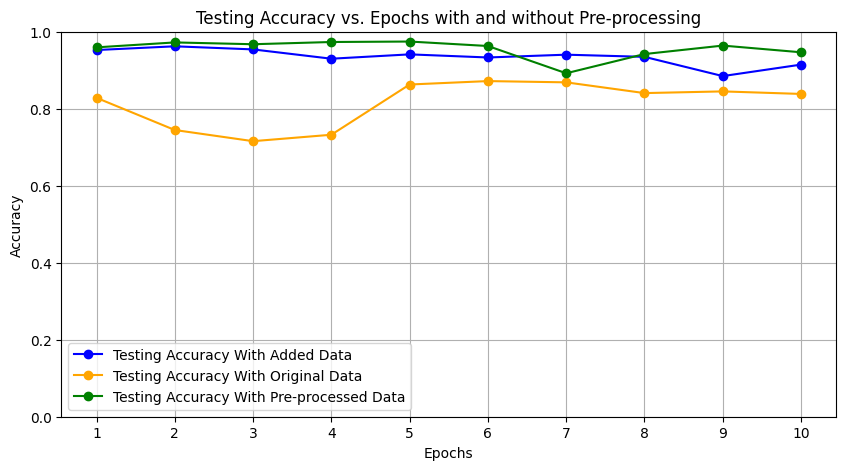

In [23]:
epochs = list(range(1, num_epochs + 1))

plt.figure(figsize=(10, 5))

plt.plot(epochs, added_res, label='Testing Accuracy With Added Data', marker='o', color='blue')

plt.plot(epochs, original_res, label='Testing Accuracy With Original Data', marker='o', color='orange')

plt.plot(epochs, removed_res, label='Testing Accuracy With Pre-processed Data', marker='o', color='green')

plt.title('Testing Accuracy vs. Epochs with and without Pre-processing')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.ylim(0, 1)
plt.grid()
plt.legend()
plt.show()

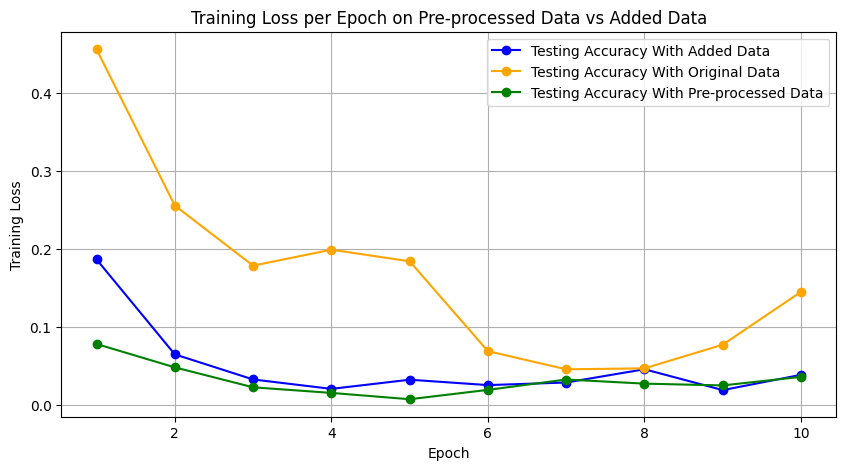

In [24]:
plt.figure(figsize=(10, 5))

plt.plot(range(1, num_epochs + 1), added_losses, label='Testing Accuracy With Added Data', marker='o', color='blue')
plt.plot(range(1, num_epochs + 1), original_losses, label='Testing Accuracy With Original Data', marker='o', color='orange')
plt.plot(range(1, num_epochs + 1), removed_losses, label='Testing Accuracy With Pre-processed Data', marker='o', color='green')

# Adding labels and title
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss per Epoch on Pre-processed Data vs Added Data")
plt.legend()
plt.grid(True)
plt.show()